For this problem, we are using functional data from various sensors to ultimately determine which sensors are most correlated with air/fuel ratio. To do so, however, we must perform some data manipulation to (1) simplify the data, and (2) make the data suitable for group lasso, in order to be able to use group lasso to answer our question at hand. Thus, I will go through each step required to perform the task at hand.

Below, I load all my needed packages.

In [1]:
import pandas as pd 
import numpy as np 
from group_lasso import GroupLasso
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge, RidgeCV, LassoCV, lasso_path, ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from scipy import io
from scipy.interpolate import BSpline

In [2]:
def BSplineBasis(x: np.array, knots: np.array, degree: int) -> np.array:
    # This is directly taken from Practice Code
    nKnots = knots.shape[0]
    lo = min(x[0], knots[0])
    hi = max(x[-1], knots[-1])
    augmented_knots = np.append(
        np.append([lo]*degree, knots), [hi]*degree)
    DOF = nKnots + degree +1 # DOF = K+M, M = degree+1
    spline = BSpline(augmented_knots, np.eye(DOF),
                     degree, extrapolate=False)
    B = spline(x)
    return B

Next, I load the data

In [3]:
x = io.loadmat(r'../NSC.mat')['x']
y = io.loadmat(r'../NSC.mat')['y']
x_test = io.loadmat(r'../NSC.test.mat')['x_test']
y_test = io.loadmat(r'../NSC.test.mat')['y_test']

# Part A - Plot the Data

Below, I will plot all the various function data measures for each sensor. As can be seen, for each sensor, 150 separate data points are captured over 203 periods:

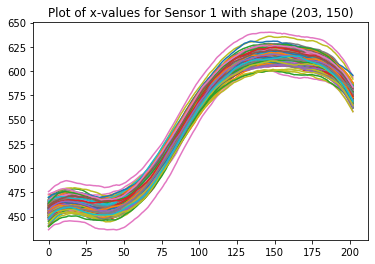

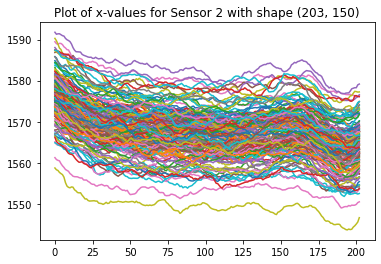

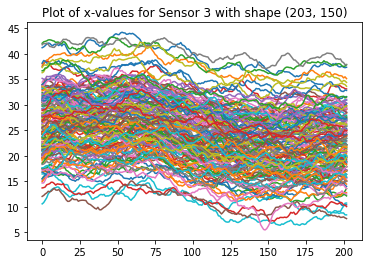

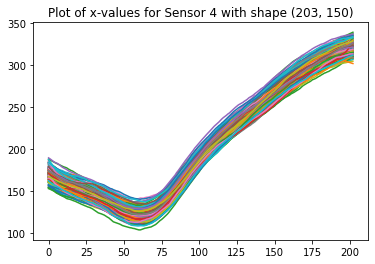

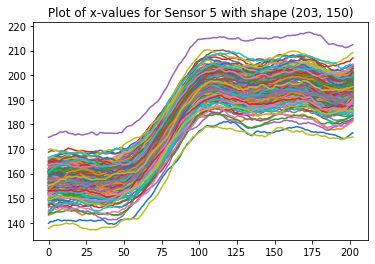

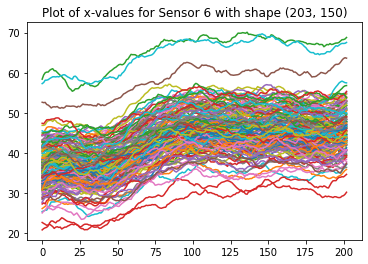

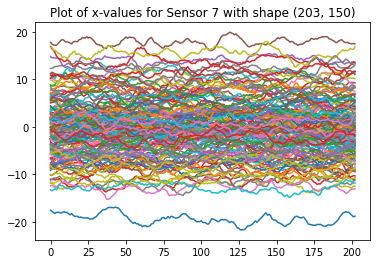

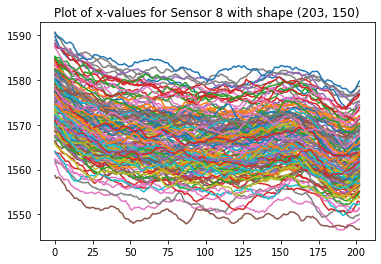

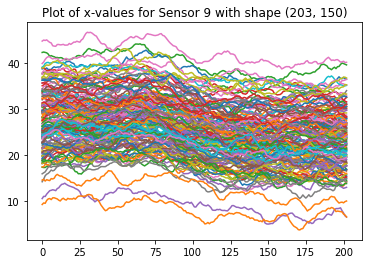

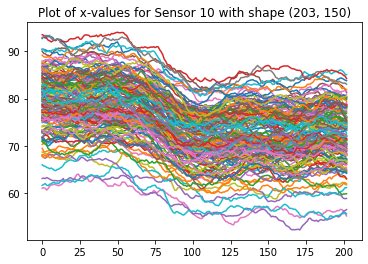

In [4]:
for i in range(10):
    plt.title(f"Plot of x-values for Sensor {i+1} with shape {x[0,i].T.shape}")
    plt.plot(x[0,i].T)
    plt.show()

Next, I will plot the dependent variable measures, which is also in the form of functional data, and in this case represents our air/fuel ratios:

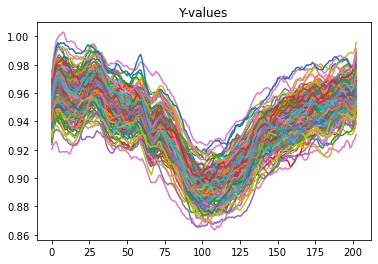

In [5]:
plt.plot(y.T)
plt.title('Y-values')
plt.show()

# Part B: B-Spline

Next, because our data is so high-dimensional, I will use B-spline transformations with 8 knots, as given to us in the instructions, to reduce dimensionality to 10 total columns for all 150 rows of measurement, leading to a final list of 10 matrices (one per sensor), each of size 150x10. (10, because we have 8 knots and 2 endpoints). 

### X-values

In [6]:
kn = 8
B = BSplineBasis(np.linspace(0,1,x[0,0].shape[1]),np.linspace(0,1,kn),3)[:,:-2]
BS_x = []
for i in range(10):
    Bcoef = np.linalg.lstsq(B,x[0,i].T,rcond=None)[0].T
    BS_x.append(Bcoef)

Above, I use Bspline Basis to get the knots, and I can even plot the smoothed curves below by using these knots and the original basis again to recreate a smoothed version of the original data. Note, while these graphical representations are shown to prove B-spline transformation worked, and have the same dimensions as the original data, I will be using the reduced-dimension matrices for further analysis, NOT those calculated below:

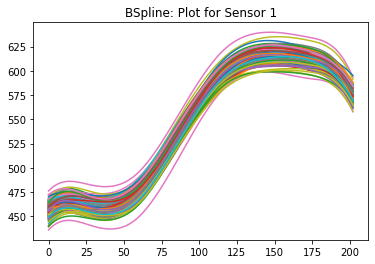

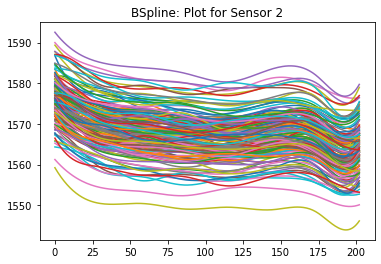

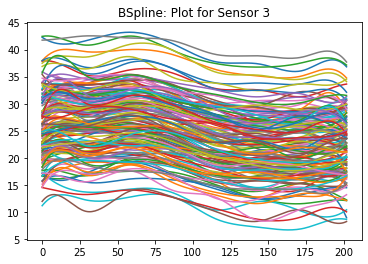

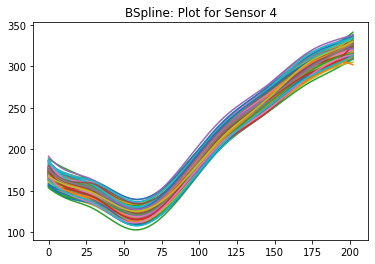

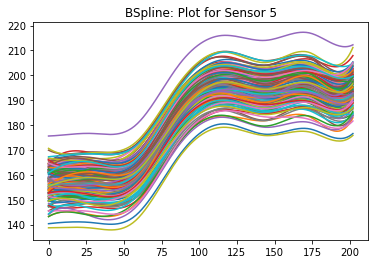

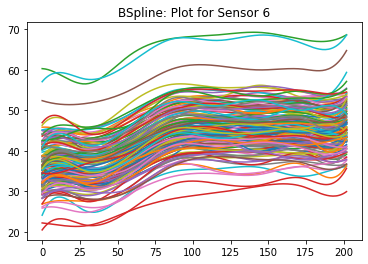

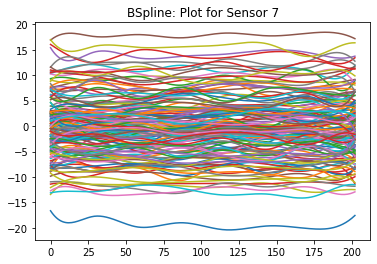

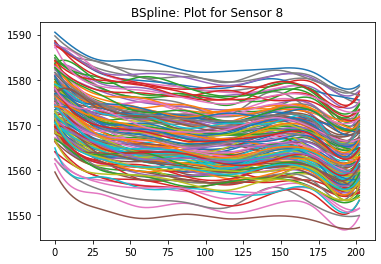

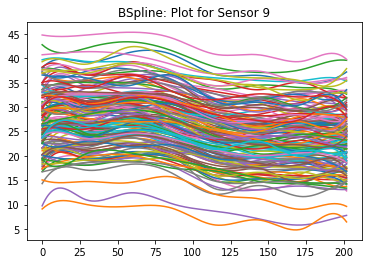

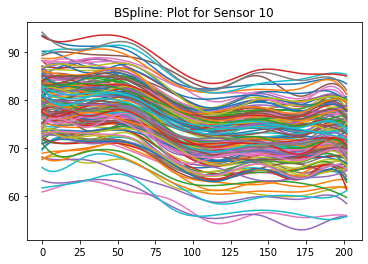

In [7]:
for i in range(10):
    plt.title(f"BSpline: Plot for Sensor {i+1}")
    plt.plot((BS_x[i]@B.T).T)
    plt.show()

As we can see, it looks very successful in terms of smoothing out the curves while keeping a similar structure! Thus, I have faith in my process and will use my reduced-dimension matrices for further analysis.

Now, I can perform the same transformation and graphical representation for Y:

### Y-values

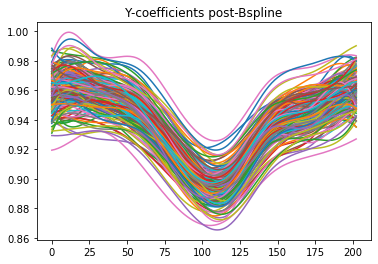

In [8]:
kn = 8
By = BSplineBasis(np.linspace(0,1,y.shape[1]),np.linspace(0,1,kn),3)[:,:-2]
B_y_coef = np.linalg.lstsq(By,y.T,rcond=None)[0].T
plt.plot((B_y_coef@By.T).T)
plt.title("Y-coefficients post-Bspline")
plt.show()

Just to prove that it worked, as well, Below I print the size of the reduced-dimensionality result for Y, which should be 150x10:

In [9]:
print(f"Final size per matrix: {B_y_coef.shape}")

Final size per matrix: (150, 10)


# Part D

Now comes the fun part! Once I have my reduced-dimensionality matrices, I can use group lasso regularization to extract coefficients and get an idea as to which sensors are more correlated with the y-values.

But, before I can do so, I need to turn my data into 2 dimensions to be properly used by the group lasso function. Thus, I will form a stacked matrix, by taking the kron-product of an identity matrix and the original 3D X matrix, and will flatten Y, to get a final matrix of predicotrs, sizes 1500 by 1000, and the y-matrix to be size 1500. 

In [10]:
Z = np.hstack(BS_x)
I = np.eye(10)
Z_stack = np.kron(I,Z)
Y_stack = B_y_coef.flatten()

Next, I run group lasso! First, I create the groups, as an input to the function for grouping. Then, I tune the model using various levels of possible lambda and alpha values, using a gridsearchCV function to tune the optimal parameters. And then, as always, I fit the model using the stacked data (the training data). From this, I will be able to perform further analysis as to the correlation between sensors and Y.

In [11]:
group = sum([[i]*10 for i in range(1, 101)], [])
lambdas, _, _ = lasso_path(Z_stack, Y_stack)
glreg = GroupLasso(tol=.1,groups=group, group_reg=0, l1_reg=0, fit_intercept=True,
        scale_reg='none',supress_warning=True)
CV = GridSearchCV(glreg, param_grid={
                  'group_reg': lambdas[::10], 'l1_reg':np.arange(.1,1.1,.5)}, scoring='neg_mean_squared_error', verbose=1)
CV.fit(Z_stack, Y_stack)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(estimator=GroupLasso(group_reg=0,
                                  groups=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
                                          2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3,
                                          3, 3, 3, 3, ...],
                                  l1_reg=0, scale_reg='none',
                                  supress_warning=True, tol=0.1),
             param_grid={'group_reg': array([149.49878708,  74.40589861,  37.03199107,  18.43090922,
         9.17310695,   4.56547694,   2.27224863,   1.1309035 ,
         0.56285334,   0.28013343]),
                         'l1_reg': array([0.1, 0.6])},
             scoring='neg_mean_squared_error', verbose=1)

Because this function takes an incredibly long time for really low tolerances in Python, I had to suffer potential fine-tuning ability for better run-time, but ideally I would have been able to tune with a tolerance of 1e-4 or less, and thus more iterations to be able to reach lower tolerances. Even then, as an exercise, this should be sufficient for getting a reasonable final result.

In [12]:
coef = CV.best_estimator_.coef_.ravel()
lam = CV.best_params_['group_reg']
coef = coef.reshape((100, 10))

### Testing for importance of sensors:

Next, as described in Piazza, each group of 10 rows in the coefficient matrix relate to one of the 10 sensors (first 10 to sensor 1, next 10 to sensor 2, and so forth). Thus, to understand the importance of each sensor on the y-values, I can simply take the l2-norm distance of all the coefficients within one sensor's rows of coefficients. The sensors with the highest values are those that are most correlated with the response variable.

In [13]:
sensor_importance = []
for a,s in zip(np.arange(0,100,10),range(0,10)):
    b = a+10
    coefs_temp = coef[a:b,:]
    lev = np.linalg.norm(coefs_temp)
    sensor_importance.append((s+1,lev))

In [14]:
pd.DataFrame(sensor_importance).sort_values(by=1,ascending=False).rename({0:'Sensor Ref',1:'L2 Norm of Coefs'},axis=1)

,Sensor Ref,L2 Norm of Coefs
5,6,5.337726e-07
1,2,5.259435e-07
4,5,4.256462e-07
0,1,0.000000e+00
2,3,0.000000e+00
3,4,0.000000e+00
6,7,0.000000e+00
7,8,0.000000e+00
8,9,0.000000e+00
9,10,0.000000e+00


As can be seen, the only sensors that seem at all correlated with the response variable are sensors 6 (acceleator pedal position)... Sensor 2 (Engine Rotational Speed)... and Sensor 5 (Inner Torque). The rest of the sensors have a completely 0 value of the l2-norm among the coefficients, meaning they are irrelevant for predicting the response variable post-group lasso regularization. 

# Part E: Predict Test Set

Now that I have my final model built, I can test it on the test set data, to see how well it actually performs, which will also give me an idea of how confident I can be in analysis in part D.

To predict on a test set, I have to perform the same transformations to the test set to be able to be predictable. Thus, I reduce dimensionality of the new test set for the predictors and the y-measures, and perform the same stacking methods to get my data in the right format for prediction.

In [15]:
BS_x_test = []
for i in range(10):
    Bcoef = np.linalg.lstsq(B,x_test[0,i].T,rcond=None)[0].T
    BS_x_test.append(Bcoef)

B_y_test = np.linalg.lstsq(By,y_test.T,rcond=None)[0].T

In [16]:
Z_t = np.hstack(BS_x_test)
I_t = np.eye(10)
Z_stack_t = np.kron(I_t,Z_t)
Y_stack_t = B_y_test.flatten()

With this done, I can predict on my new transformed regressor matrix, and test the mean_squared_error. I take my final optimized parameters from cross-validation and build a final group lasso model with these parameters:

In [17]:
print(f"Optimal Group Reg Parameter: {CV.best_params_['group_reg']}... Optimal alpha: {CV.best_params_['l1_reg']}")

Optimal Group Reg Parameter: 0.28013343192484064... Optimal alpha: 0.1


In [18]:
glreg = GroupLasso(tol=.0001,groups=group, group_reg=CV.best_params_['group_reg'], l1_reg=CV.best_params_['l1_reg'], n_iter=1000000, fit_intercept=True,
        scale_reg='none',supress_warning=True).fit(Z_stack, Y_stack)

In [19]:
pr = glreg.predict(Z_stack_t)
print(f"The mean-squared-error of prediction: {mean_squared_error(Y_stack_t,pr)}")

The mean-squared-error of prediction: 0.03920484716982076
